<a href="https://colab.research.google.com/github/ChrisFJardine/Masterclass/blob/main/CJardineAssignment3__NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import re
import time
import datetime
import os
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from wordcloud import WordCloud
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import CategoricalNB
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn
from pprint import pprint
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm


%matplotlib inline 
from datetime import datetime, timedelta

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [187]:
#Load raw corpus and sentiment and reshape
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/ExtractedNews.csv', header = None)
sentiment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/df_grouped_sentiment.csv')
docs = []
for x in range(news.shape[1]):
  for y in range(news.shape[0]):
    if isinstance(news[x][y], str):
      docs.append(news[x][y])
df = pd.DataFrame(docs)

In [188]:
#Wrangle for NLP
df['date'] = df[0].apply(lambda x: datetime.strptime(re.search(r'\d{4}-\d{2}-\d{2}', str(x)).group(),'%Y-%m-%d').date()) #Remove exess date string
df['text'] = df[0].str.replace('[^\w\s]', '')                                  #remove punctuation
df['text'] = df['text'].str.replace('\d+','')                                  #remove numbers
df['text'] = df['text'].str.lstrip()                                           #remove leading spaces
#df['text'] = df['text'].str.lower()                                           #all to lower case
df = df.drop(df.columns[[0]], 1)
df.sort_values(by='date', inplace=True)


In [189]:
#Merge the corpus with the daily sentiment values
sentiment.date = pd.to_datetime(sentiment.date)
df.date = pd.to_datetime(df.date)
df = df.merge(sentiment, on = 'date', how = 'left')

In [206]:
ABC_staff = ['Grandstands Luke Pentony','Laura Tingle','Kerry Lonergan','Leigh Sales','John Barron','Mark Humphries','Shannon Byrne','Grandstands Alister Nicholson', 'Rachael','Richard Svenson','Zane Bojack','Lateline','Grandstands Dan Lonergan','Laurie Spina','Steve Mascord','Grandstands Craig Hamilton','Adam White']

In [207]:
df2012 = df[( df['date'] > pd.Timestamp(2012,1,1))  &  (df['date'] < pd.Timestamp(2013,1,1)) ] 
listwords2012 = ' '.join([x for x in df2012.text]).split()

df2019 = df[( df['date'] > pd.Timestamp(2019,1,1))  &  (df['date'] < pd.Timestamp(2020,1,1)) ] 
listwords2019 = ' '.join([x for x in df2019.text]).split()

df2020 = df[( df['date'] > pd.Timestamp(2020,1,1))  &  (df['date'] < pd.Timestamp(2021,1,1)) ] 
listwords2020 = ' '.join([x for x in df2020.text]).split()

data = pd.concat([df2012, df2019, df2020])

In [192]:
print('2012 corpus length : ' + str(len(df2012)))
print('2019 corpus length : ' + str(len(df2019)))
print('2020 corpus length : ' + str(len(df2020)))

2012 corpus length : 9280
2019 corpus length : 8749
2020 corpus length : 6484


In [193]:
def extract_sent_named_enities(sent):
  list_ents = []
  ents = nlp(sent)
  for ent in ents.ents:
    if ent.label_ == 'PERSON' and ent.text not in ABC_staff:
      list_ents.append(ent.text)
  list_ents = [x.replace('Donald Trumps', 'Donald Trump') for x in list_ents]
  list_ents = [x.replace('Trumps', 'Donald Trump') for x in list_ents]
  return(list_ents)

In [ ]:
def standardise_trump(ents):
  ents = [x.replace('Donald Trumps', 'Donald Trump') for x in ents]
  ents = [x.replace('Trumps', 'Donald Trump') for x in ents]
  return(ents)

In [184]:
df['text'] = df.apply(lambda x: standardise_trump(x.text), axis = 1)

In [194]:
nlp = en_core_web_sm.load()
data['entities'] = data.apply(lambda x: extract_sent_named_enities(x.text), axis = 1)
data = data[data['entities'].apply(lambda x: len(x)) > 0]


,date,text,doc_sentiment,tokenised_avg_sentiment,entities
9261,2012-01-02,An unbeaten run partnership between Brad Hodge...,0.025144,0.026512,"[Brad Hodge, Andrew McDonald]"
9262,2012-01-02,The Federal Government has cautiously welcomed...,0.025144,0.026512,[Commodore Frank Bainimaramas]
9263,2012-01-02,British artist David Hockney has responded to ...,0.025144,0.026512,[David Hockney]
9264,2012-01-02,Alviro Petersen will open the batting for Sout...,0.025144,0.026512,"[Alviro Petersen, Graeme Smith]"
9266,2012-01-02,Melbourne Renegades captain Andrew McDonald to...,0.025144,0.026512,"[Melbourne Renegades, Andrew McDonald, Sydney ..."


In [116]:
data.shape

(12660, 5)

In [34]:
def extract_named_enities(df, stopnames = []):
  list_ents = []
  for text in df['text']:
    ents = nlp(text)
    for ent in ents.ents:
      if ent.label_ == 'PERSON' and ent.text not in stopnames:
        list_ents.append(ent.text)
  return(list_ents)

In [35]:
def plot_entities(entity_list):
  fdist = FreqDist(entity_list).most_common(20)
  all_fdist = pd.Series(dict(fdist))
  fig, ax = plt.subplots(figsize=(20,10))
  all_plot = seaborn.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
  plt.xticks(rotation=60);

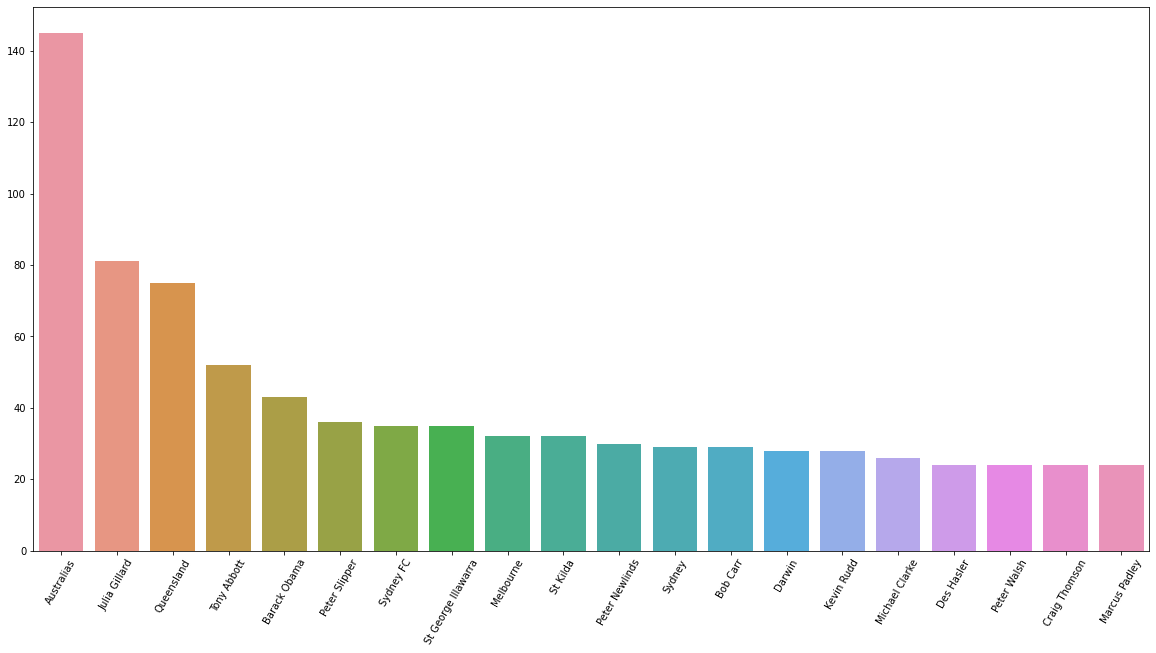

In [46]:
plot_entities(extract_named_enities(df2012, ABC_staff))

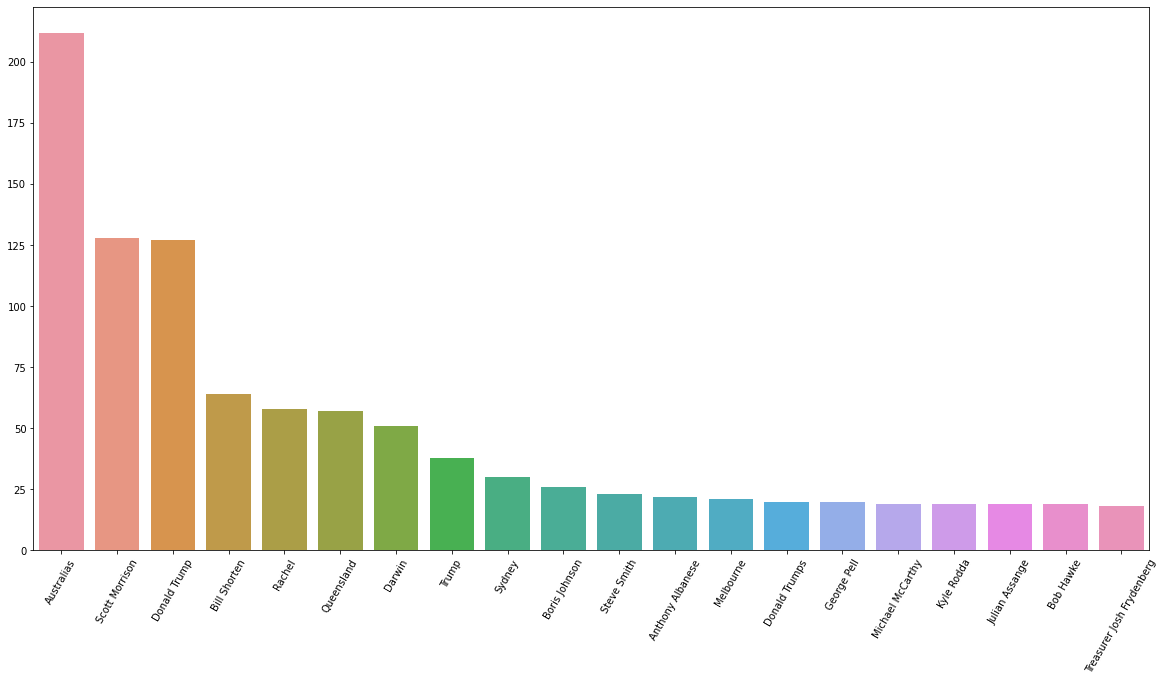

In [181]:
plot_entities(extract_named_enities(df2019, ABC_staff))

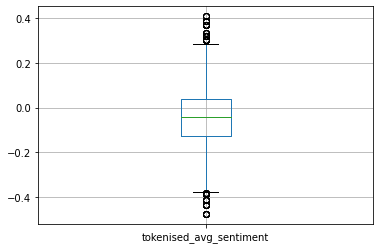

In [146]:
#Review the spread of average sentiment 
data.boxplot(column = 'tokenised_avg_sentiment')

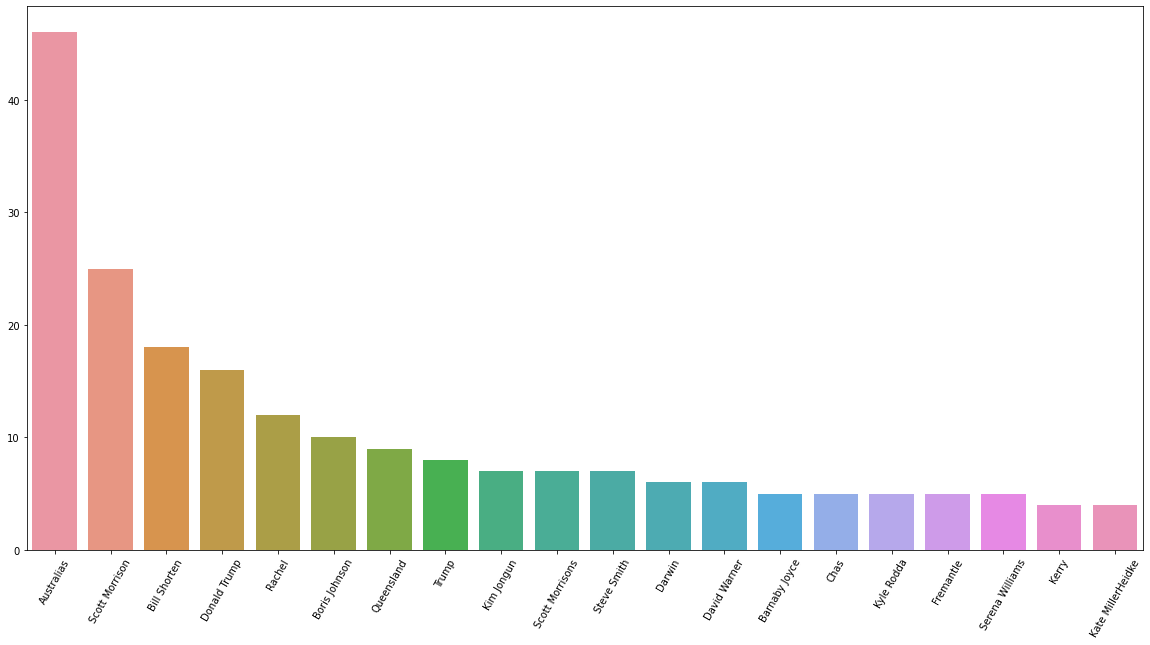

In [208]:
#Lets assume above 0 is Good News and see who produced positive sentiment in 2019:)
good_news = df2019.loc[df2019['tokenised_avg_sentiment'] > 0 ]
plot_entities(extract_named_enities(good_news, ABC_staff))


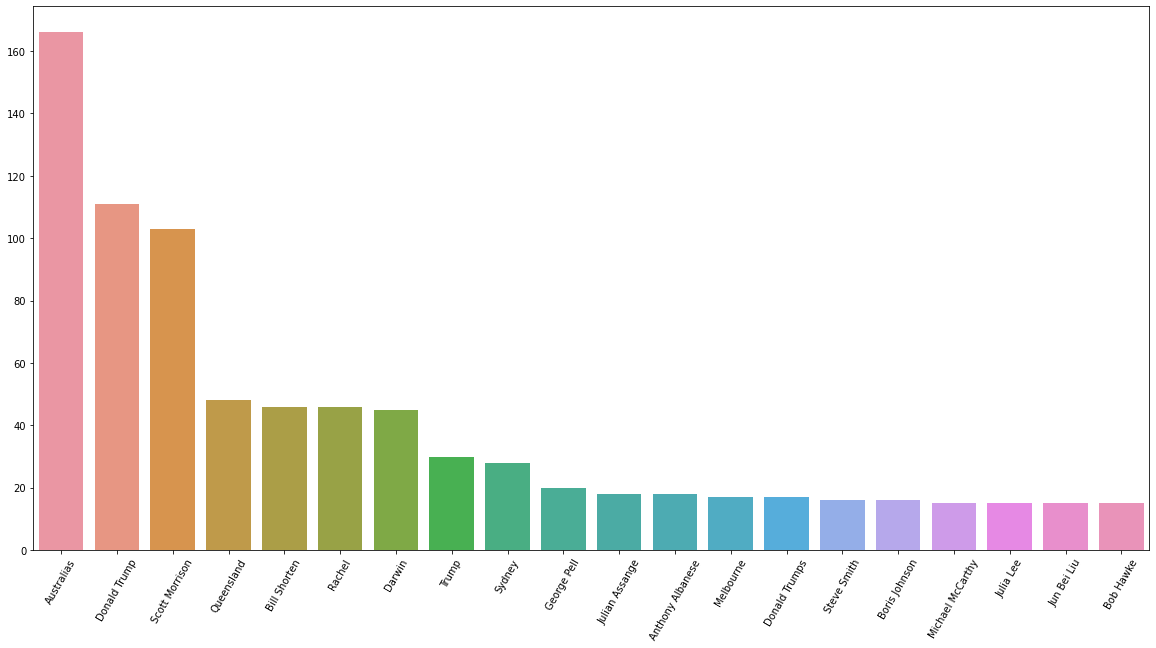

In [209]:
#and now the bad news
bad_news = df2019.loc[df2019['tokenised_avg_sentiment'] < 0 ]
plot_entities(extract_named_enities(bad_news, ABC_staff))
